In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.style.use('seaborn')
sns.set(font_scale=2)
import missingno as msno
import os
import csv

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.set_random_seed(777)
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_train = pd.read_csv('./data/train_a.csv')

In [3]:
df_train.tail()

,date&time,WashingMachine,Dryer,temp,icon,hum,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,dayOfWeeks
25891,2016-12-14 19:00,0.000850,0.003150,15.44,clear-night,0.67,10.00,Clear,15.44,1012.98,2.44,0.04,1481760000,224.0,0.0,6.43,0.0,1
25892,2016-12-14 20:00,0.002067,0.003150,14.11,clear-night,0.69,9.84,Clear,5.99,1012.14,5.06,0.24,1481763600,159.0,0.0,5.93,0.0,1
25893,2016-12-14 21:00,0.002450,0.003133,17.34,clear-night,0.64,10.00,Clear,17.34,1010.64,2.88,0.18,1481767200,123.0,0.0,7.16,0.0,1
25894,2016-12-14 22:00,0.002567,0.003433,18.26,partly-cloudy-night,0.64,9.98,Partly Cloudy,12.71,1009.88,3.65,0.42,1481770800,118.0,0.0,8.12,0.0,1
25895,2016-12-14 23:00,0.001983,0.003400,20.73,partly-cloudy-night,0.62,10.00,Partly Cloudy,11.14,1009.07,7.97,0.31,1481774400,204.0,0.0,9.88,0.0,1


In [4]:
train_data = [df_train]

icon_mapping = {'clear-day':0, 'clear-night':1, 'cloudy':2, 'fog':3, 'partly-cloudy-day':4, 'partly-cloudy-night':5, 'rain':6, 'snow':7, 'wind':8}
for dataset in train_data:
    dataset['icon'] = dataset['icon'].map(icon_mapping)

In [5]:
train_data = [df_train]

for dataset in train_data:
    dataset['time'] = dataset['date&time'].str.extract('(\d*[:]\d*)', expand=False)

In [6]:
df_train.drop(['date&time', 'visibility', 'summary', 'precipIntensity', 'precipProbability', 'icon', 'apparentTemperature', 'pressure', 'windSpeed', 
              'cloudCover', 'windBearing', 'dewPoint', 'WashingMachine'], axis=1, inplace=True)

In [7]:
time_mapping = {"0:00":0, "1:00":1, "2:00":2, "3:00":3, "4:00":4, "5:00":5, "6:00":6, "7:00":7, "8:00":8, "9:00":9, "10:00":10,
               "11:00":11, "12:00":12, "13:00":13, "14:00":14, "15:00":15, "16:00":16, "17:00":17, "18:00":18, "19:00":19, "20:00":20, "21:00":21, 
               "22:00":22, "23:00":23}
for dataset in train_data:
    dataset['time'] = dataset['time'].map(time_mapping)

In [8]:
df_train.head()

,Dryer,temp,hum,time,dayOfWeeks
0,0.005441,16.67,0.53,0.0,3
1,0.005317,16.19,0.52,1.0,3
2,0.005368,15.69,0.55,2.0,3
3,0.005527,15.29,0.58,3.0,3
4,0.005630,15.37,0.60,4.0,3


In [9]:
df_train['dayOfWeeks'].value_counts()

4    3720
3    3720
6    3696
5    3696
1    3696
0    3696
2    3672
Name: dayOfWeeks, dtype: int64

In [10]:
# 요일 별 분류

df_sun = df_train.loc[df_train['dayOfWeeks'] == 0]
df_mon = df_train.loc[df_train['dayOfWeeks'] == 1]
df_tue = df_train.loc[df_train['dayOfWeeks'] == 2]
df_wen = df_train.loc[df_train['dayOfWeeks'] == 3]
df_thu = df_train.loc[df_train['dayOfWeeks'] == 4]
df_fri = df_train.loc[df_train['dayOfWeeks'] == 5]
df_sat = df_train.loc[df_train['dayOfWeeks'] == 6]

In [11]:
dryer_mean = df_thu['Dryer'].mean()
print(dryer_mean)
df_np = df_thu.values.astype(np.float)
print(np.shape(df_np))

0.08224134453655914
(3720, 5)


In [12]:
df_np_hour = []
for i in range((int(len(df_np)/24))):
    df_np_hour.append(df_np[i*24:i*24+24])

In [13]:
np.shape(df_np_hour)

(155, 24, 5)

In [14]:
delete_row = []

for i in range(len(df_np_hour)):
    cnt = 0
    for j in range(len(df_np_hour[i])):
        if(df_np_hour[i][j][0] < dryer_mean):
            cnt += 1
    
    if(cnt == 24):
        delete_row.append(i)


In [15]:
np.shape(df_np_hour)

(155, 24, 5)

In [16]:
cnt = 0
for i in range(len(delete_row)):
    df_np_hour = np.delete(df_np_hour, (i - cnt), axis=0)
    cnt += 1

In [17]:
np.shape(df_np_hour)

(51, 24, 5)

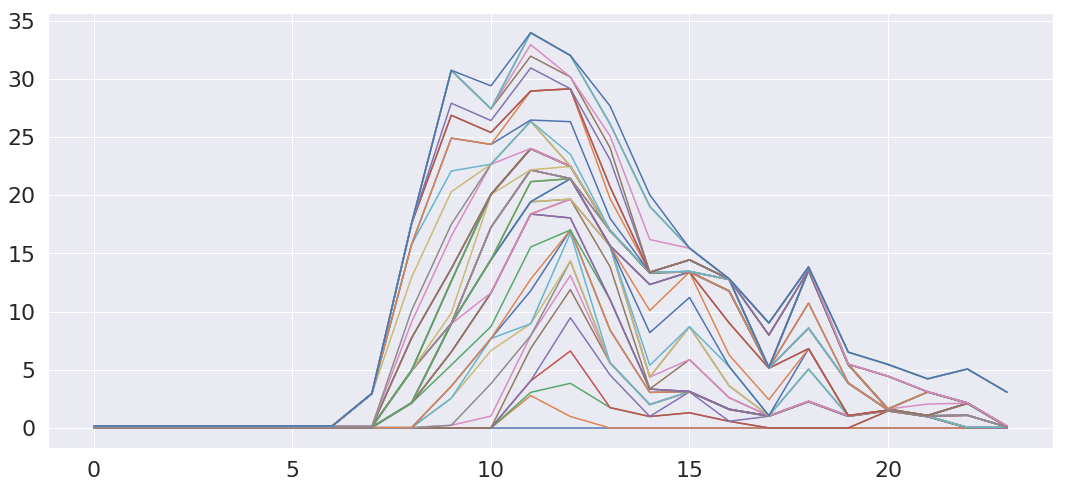

[ 0.  0.  0.  0.  0.  0.  0.  1.  8. 17. 15. 21. 18. 16. 13.  8.  9.  5.
  7.  4.  3.  4.  3.  1.]


In [18]:
pattern_priority = np.zeros(24)
pattern_count = np.zeros(24)

plt.figure(figsize=(18, 8))
for i in range(len(df_np_hour)):
    for j in range(len(df_np_hour[i])):
        pattern_priority[j] += df_np_hour[i][j][0]
        if(df_np_hour[i][j][0] > dryer_mean):
            pattern_count[j] += 1
    plt.plot(pattern_priority)
plt.show()

print(pattern_count)

In [19]:
df_all_np = []

for i in range(len(df_np_hour)):
    for j in range(len(df_np_hour[i])):
        temp = []
        for k in range(len(df_np_hour[i][j])):
            temp.append(df_np_hour[i][j][k])
        df_all_np.append(temp)

In [20]:
np.shape(df_all_np)

(1224, 5)

In [21]:
df_all_np = np.array(df_all_np)

In [22]:
scaler = MinMaxScaler()

device = df_all_np[:, 0:1]

temp = df_all_np[:, 1:2]
norm_temp = scaler.fit_transform(temp)

hum = df_all_np[:, 2:3]
norm_hum = scaler.fit_transform(hum)

time = df_all_np[:, 3:4]
norm_time = scaler.fit_transform(time)

day = df_all_np[:, -1:]
norm_day = scaler.fit_transform(day)

x = np.concatenate((norm_time, norm_temp, norm_hum, device, norm_day), axis=1)
print('x.shape ', x.shape)
print('x[0] ', x[0])
print('x[-1]', x[-1])

y = device
print('y[-1]', y[-1])

x.shape  (1224, 5)
x[0]  [0.         0.47060597 0.94047619 0.0038     0.        ]
x[-1] [1.         0.25776304 0.76190476 0.00343333 0.        ]
y[-1] [0.00343333]


In [23]:
input_data_column_cnt = 5
output_data_column_cnt = 1

seq_length = 1
rnn_cell_hidden_dim = 30
forget_bias = 1.0
num_stacked_layers = 2
keep_prob = 1.0

epoch_num = 300
learning_rate = 0.0001

In [24]:
dataX = []
dataY = []

for i in range(0, len(y) - seq_length):
    _x = x[i:i+seq_length]
    _y = y[i+seq_length]
    if i is 0:
        print(_x, '->', _y)
    dataX.append(_x)
    dataY.append(_y)

[[0.         0.47060597 0.94047619 0.0038     0.        ]] -> [0.00383333]


In [25]:
print(len(dataY))

train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

trainX = np.array(dataX[0:train_size])
trainY = dataY[0:train_size]

testX = np.array(dataX[train_size:len(dataX)])
testY = dataY[train_size:len(dataY)]

print(np.shape(trainY))

1223
(856, 1)


In [26]:
print(train_size, test_size)

856 367


In [27]:
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt], name='X')
print(X)
Y = tf.placeholder(tf.float32, [None, 1], name='Y')
print(Y)

targets = tf.placeholder(tf.float32, [None, 1], name='train_Y')
print(targets)

predictions = tf.placeholder(tf.float32, [None, 1], name='predicted_Y')
print(predictions)

Tensor("X:0", shape=(?, 1, 5), dtype=float32)
Tensor("Y:0", shape=(?, 1), dtype=float32)
Tensor("train_Y:0", shape=(?, 1), dtype=float32)
Tensor("predicted_Y:0", shape=(?, 1), dtype=float32)


In [28]:
def lstm_cell():
    cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_cell_hidden_dim, activation=tf.nn.relu)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.nn.relu)

Instructions for updating:
Use the retry module or similar alternatives.
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 1, 30), dtype=float32)


In [29]:
loss = tf.reduce_sum(tf.square(hypothesis - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)

train = optimizer.minimize(loss)
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

# SAVER_DIR = "./Model"
# saver = tf.train.Saver()
# checkpoint_path = os.path.join(SAVER_DIR, 'sun_model')
# ckpt = tf.train.get_checkpoint_state(SAVER_DIR)

In [30]:
train_error_summary = []
test_error_summary = []
test_predict = ''
predict_array = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

start_time = datetime.datetime.now()
print('학습 시작')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X:trainX, Y:trainY})
    
    train_predict = sess.run(hypothesis, feed_dict = {X:trainX})
    train_error = sess.run(rmse, feed_dict = {targets:trainY, predictions:train_predict})
    train_error_summary.append(train_error)

    test_predict = sess.run(hypothesis, feed_dict={X:testX})
    test_error = sess.run(rmse, feed_dict={targets:testY, predictions:test_predict})
    test_error_summary.append(test_error)
        
    if((epoch+1) % 10 == 0) or (epoch == epoch_num - 1):
#         saver.save(sess, checkpoint_path, global_step=epoch)
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print('elapsed_time:', elapsed_time)
print('elapsed_time per epoch:', elapsed_time/epoch_num)
predict_array.append(test_predict)

학습 시작
epoch: 10, train_error(A): 0.628938615322113, test_error(B): 0.6970853805541992, B-A: 0.06814676523208618
epoch: 20, train_error(A): 0.6252927780151367, test_error(B): 0.6915512084960938, B-A: 0.06625843048095703
epoch: 30, train_error(A): 0.6220145225524902, test_error(B): 0.6865158677101135, B-A: 0.06450134515762329
epoch: 40, train_error(A): 0.6190719604492188, test_error(B): 0.6819378733634949, B-A: 0.06286591291427612
epoch: 50, train_error(A): 0.6163903474807739, test_error(B): 0.6777608394622803, B-A: 0.06137049198150635
epoch: 60, train_error(A): 0.613946259021759, test_error(B): 0.6740460991859436, B-A: 0.06009984016418457
epoch: 70, train_error(A): 0.6116678714752197, test_error(B): 0.6706777811050415, B-A: 0.05900990962982178
epoch: 80, train_error(A): 0.6095530986785889, test_error(B): 0.667606770992279, B-A: 0.058053672313690186
epoch: 90, train_error(A): 0.6076250672340393, test_error(B): 0.6647457480430603, B-A: 0.057120680809020996
epoch: 100, train_error(A): 0.60

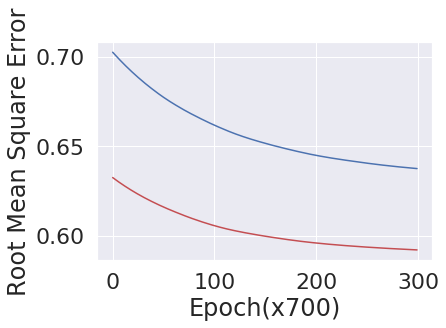

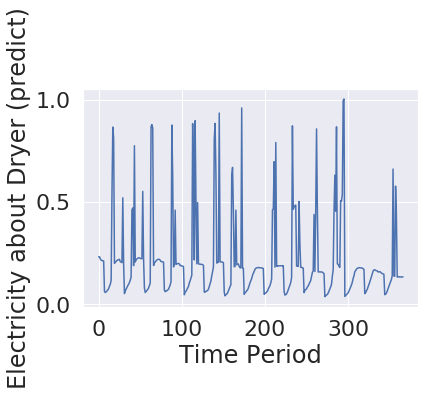

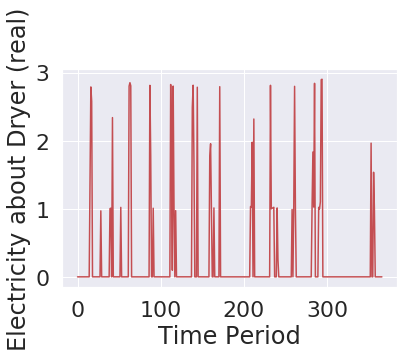

In [31]:
plt.figure(1)
plt.plot(train_error_summary, 'r')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x700)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Electricity about Dryer (predict)')

plt.figure(3)
plt.plot(testY, 'r')
plt.xlabel('Time Period')
plt.ylabel('Electricity about Dryer (real)')
plt.show()

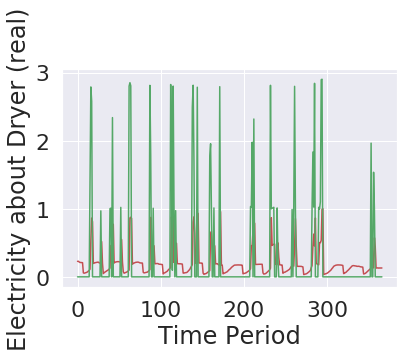

In [32]:
plt.figure()
plt.plot(predict_array[0],'r')
plt.plot(testY, 'g')
plt.xlabel('Time Period')
plt.ylabel('Electricity about Dryer (real)')
plt.show()

In [33]:
testY = np.array(testY)
scaler2 = MinMaxScaler(feature_range = (0, testY.max()))
predict_array[0] = scaler2.fit_transform(predict_array[0])

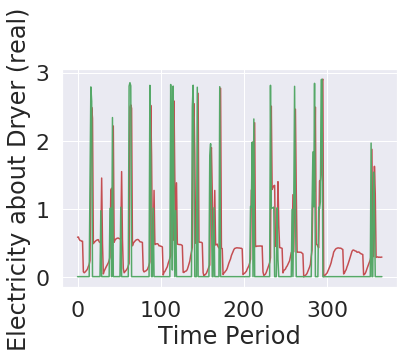

In [34]:
plt.figure()
plt.plot(predict_array[0],'r')
plt.plot(testY, 'g')
plt.xlabel('Time Period')
plt.ylabel('Electricity about Dryer (real)')
plt.show()

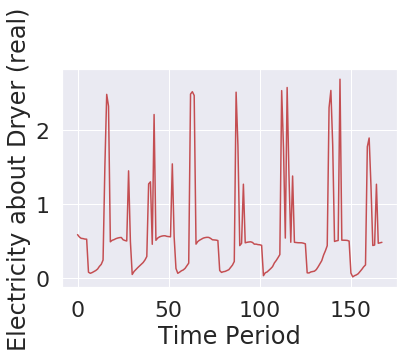

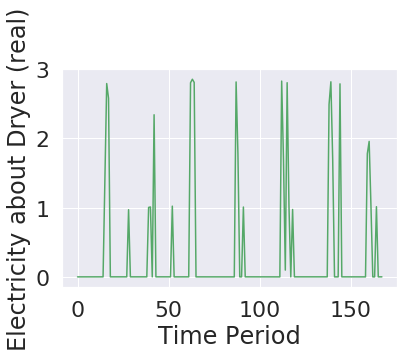

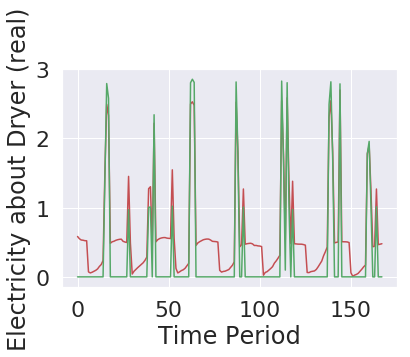

In [35]:
plt.figure(1)
plt.plot(predict_array[0][1:169],'r')
plt.xlabel('Time Period')
plt.ylabel('Electricity about Dryer (real)')
plt.show()

plt.figure(2)
plt.plot(testY[:168], 'g')
plt.xlabel('Time Period')
plt.ylabel('Electricity about Dryer (real)')
plt.show()

plt.figure(3)
plt.plot(predict_array[0][1:169],'r')
plt.plot(testY[:168], 'g')
plt.xlabel('Time Period')
plt.ylabel('Electricity about Dryer (real)')
plt.show()

In [41]:
w = open('./dryer_test_data.csv', 'w', encoding='utf-8')
wr = csv.writer(w)

w2 = open('./dryer_predicted_data.csv', 'w', encoding='utf-8')
wr2 = csv.writer(w2)

w3 = open('./dryer_used_data.csv', 'w', encoding='utf-8')
wr3 = csv.writer(w3)

for i in range(len(testY)):
    wr.writerow(testY[i])
    wr2.writerow(predict_array[0][i])
    
for i in range(len(trainY)):
    wr3.writerow(trainY[i])
    
w.close()
w2.close()
w3.close()

In [ ]:
time_electric_test = []
time_1 = 0
time_2 = 0
time_3 = 0
time_4 = 0
time_5 = 0
time_6 = 0
time_7 = 0
time_8 = 0
time_9 = 0
time_10 = 0
time_11 = 0
time_12 = 0
time_13 = 0
time_14 = 0
time_15 = 0
time_16 = 0
time_17 = 0
time_18 = 0
time_19 = 0
time_20 = 0
time_21 = 0
time_22 = 0
time_23 = 0
time_24 = 0
for i in range(len(testY)):
    if(i%24 == 0):
        time_1 += testY[i]
    elif(i%24 == 1):
        time_2 += testY[i]
    elif(i%24 == 2):
        time_3 += testY[i]
    elif(i%24 == 3):
        time_4 += testY[i]
    elif(i%24 == 4):
        time_5 += testY[i]
    elif(i%24 == 5):
        time_6 += testY[i]
    elif(i%24 == 6):
        time_7 += testY[i]
    elif(i%24 == 7):
        time_8 += testY[i]
    elif(i%24 == 8):
        time_9 += testY[i]
    elif(i%24 == 9):
        time_10 += testY[i]
    elif(i%24 == 10):
        time_11 += testY[i]
    elif(i%24 == 11):
        time_12 += testY[i]
    elif(i%24 == 12):
        time_13 += testY[i]
    elif(i%24 == 13):
        time_14 += testY[i]
    elif(i%24 == 14):
        time_15 += testY[i]
    elif(i%24 == 15):
        time_16 += testY[i]
    elif(i%24 == 16):
        time_17 += testY[i]
    elif(i%24 == 17):
        time_18 += testY[i]
    elif(i%24 == 18):
        time_19 += testY[i]
    elif(i%24 == 19):
        time_20 += testY[i]
    elif(i%24 == 20):
        time_21 += testY[i]
    elif(i%24 == 21):
        time_22 += testY[i]
    elif(i%24 == 22):
        time_23 += testY[i]
    elif(i%24 == 23):
        time_24 += testY[i]
        
time_electric_test = [time_1, time_2, time_3, time_4, time_5, time_6, time_7, time_8, time_9, time_10, time_11, time_12, time_13, time_14, time_15, time_16, time_17, time_18, time_19, time_20, time_21, time_22, time_23, time_24]

In [ ]:
time_electric_predict = []

time_1 = 0
time_2 = 0
time_3 = 0
time_4 = 0
time_5 = 0
time_6 = 0
time_7 = 0
time_8 = 0
time_9 = 0
time_10 = 0
time_11 = 0
time_12 = 0
time_13 = 0
time_14 = 0
time_15 = 0
time_16 = 0
time_17 = 0
time_18 = 0
time_19 = 0
time_20 = 0
time_21 = 0
time_22 = 0
time_23 = 0
time_24 = 0

for i in range(len(predict_array[0])):
    
    if(i%24 == 0):
        time_1 += predict_array[0][i][0]
    elif(i%24 == 1):
        time_2 += predict_array[0][i][0]
    elif(i%24 == 2):
        time_3 += predict_array[0][i][0]
    elif(i%24 == 3):
        time_4 += predict_array[0][i][0]
    elif(i%24 == 4):
        time_5 += predict_array[0][i][0]
    elif(i%24 == 5):
        time_6 += predict_array[0][i][0]
    elif(i%24 == 6):
        time_7 += predict_array[0][i][0]
    elif(i%24 == 7):
        time_8 += predict_array[0][i][0]
    elif(i%24 == 8):
        time_9 += predict_array[0][i][0]
    elif(i%24 == 9):
        time_10 += predict_array[0][i][0]
    elif(i%24 == 10):
        time_11 += predict_array[0][i][0]
    elif(i%24 == 11):
        time_12 += predict_array[0][i][0]
    elif(i%24 == 12):
        time_13 += predict_array[0][i][0]
    elif(i%24 == 13):
        time_14 += predict_array[0][i][0]
    elif(i%24 == 14):
        time_15 += predict_array[0][i][0]
    elif(i%24 == 15):
        time_16 += predict_array[0][i][0]
    elif(i%24 == 16):
        time_17 += predict_array[0][i][0]
    elif(i%24 == 17):
        time_18 += predict_array[0][i][0]
    elif(i%24 == 18):
        time_19 += predict_array[0][i][0]
    elif(i%24 == 19):
        time_20 += predict_array[0][i][0]
    elif(i%24 == 20):
        time_21 += predict_array[0][i][0]
    elif(i%24 == 21):
        time_22 += predict_array[0][i][0]
    elif(i%24 == 22):
        time_23 += predict_array[0][i][0]
    elif(i%24 == 23):
        time_24 += predict_array[0][i][0]
        
time_electric_predict = [time_1, time_2, time_3, time_4, time_5, time_6, time_7, time_8, time_9, time_10, time_11, time_12, time_13, time_14, time_15, time_16, time_17, time_18, time_19, time_20, time_21, time_22, time_23, time_24]

In [ ]:
plt.figure()
plt.plot(time_electric_test, 'r')
plt.xlabel('Time Period')
plt.ylabel('Electricity use pattern (testY)')
plt.show()

In [ ]:
plt.figure()
plt.plot(time_electric_predict[1:], 'r')
plt.xlabel('Time Period')
plt.ylabel('Electricity use pattern (predict)')
plt.show()

In [ ]:
# sunday

# input_data_column_cnt = 5
# output_data_column_cnt = 1

# seq_length = 1
# rnn_cell_hidden_dim = 15
# forget_bias = 1.0
# num_stacked_layers = 2
# keep_prob = 1.0

# epoch_num = 1000
# learning_rate = 0.0001

# input_data_column_cnt = 5
# output_data_column_cnt = 1

# seq_length = 1
# rnn_cell_hidden_dim = 40
# forget_bias = 1.0
# num_stacked_layers = 1
# keep_prob = 1.0

# epoch_num = 1000
# learning_rate = 0.0001

In [ ]:
# mon

# input_data_column_cnt = 5
# output_data_column_cnt = 1

# seq_length = 1
# rnn_cell_hidden_dim = 30
# forget_bias = 1.0
# num_stacked_layers = 2
# keep_prob = 1.0

# epoch_num = 500
# learning_rate = 0.0001

In [ ]:
# tue

# input_data_column_cnt = 5
# output_data_column_cnt = 1

# seq_length = 1
# rnn_cell_hidden_dim = 30
# forget_bias = 1.0
# num_stacked_layers = 2
# keep_prob = 1.0

# epoch_num = 700
# learning_rate = 0.0001

In [ ]:
# wen

# input_data_column_cnt = 5
# output_data_column_cnt = 1

# seq_length = 1
# rnn_cell_hidden_dim = 30
# forget_bias = 1.0
# num_stacked_layers = 2
# keep_prob = 1.0

# epoch_num = 150
# learning_rate = 0.0001